In [1]:
import tensorflow as tf

## Load Dataset

In [2]:
# load and preprocess image with given path
def decode_image(path):
    # path example: xxx\abcd.jpg
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)  # convert to floats in the [0,1] range.
    image = tf.image.resize(image, [60, 120])
    return image

# get labels
def get_labels(path, prefix):
    ''' this function is used within dataset.map(), 
        where eager execution is disables by default:
            check tf.executing_eagerly() returns False.
        So any Tensor.numpy() is not allowed in this function.
    '''
    labels = {}
    for i in range(4):
        c = tf.strings.substr(path, i-8, 1) # path example: b'xxx\abcd.jpg'
        label = tf.strings.unicode_decode(c, input_encoding='utf-8') - ord('a')
        labels[f'{prefix}_{i}'] = label
    return labels
          
# create image/labels dataset from path
def create_dataset_from_path(path_pattern, batch_size=32, label_prefix='labels'):            
    # create path dataset
    # by default, `tf.data.Dataset.list_files` gets filenames 
    # in a non-deterministic random shuffled order
    dataset = tf.data.Dataset.list_files(path_pattern).map(
        lambda image_path: (decode_image(image_path),
                            get_labels(image_path, label_prefix))).batch(batch_size)
    return dataset

In [3]:
# create (image, label) dataset from generator
train_ds = create_dataset_from_path('samples/train/*.jpg', batch_size=128)
test_ds = create_dataset_from_path('samples/test/*.jpg', batch_size=128)

## Create Model

In [13]:
def captcha_cnn(image_shape, n_labels=4, n_class=26, name='captcha', output_label='labels'):
    # input
    image_input = tf.keras.Input(shape=image_shape, name='input_image')

    # conv layer 1
    x = tf.keras.layers.Conv2D(64, (11, 23), padding='same')(image_input)
    x = tf.keras.layers.MaxPool2D((4, 4), padding='same')(x)

    # conv layer 2
    x = tf.keras.layers.Conv2D(32, (5, 11), padding='same')(x)
    x = tf.keras.layers.MaxPool2D((4, 4), padding='same')(x)

    # # conv layer 3
    # x = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(x)

    # # conv layer 4
    # x = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(x)

    # # conv layer 5
    # x = tf.keras.layers.Conv2D(64, (3, 7), padding='same')(x)
    # x = tf.keras.layers.MaxPool2D((2, 2), padding='same')(x)

    # dense layer 1
    x = tf.keras.layers.Flatten()(x) # flatten
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # # dense layer 2
    # x = tf.keras.layers.Dense(128, activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.5)(x)

    # outputs
    labels = [tf.keras.layers.Dense(n_class, name=f'{output_label}_{i}')(x) for i in range(n_labels)] 

    # build model
    model = tf.keras.Model(inputs=image_input, outputs=labels, name=name)
    
    return model

In [14]:
image_shape = (60, 120, 3)
n_labels = 4
n_class = 26

model = captcha_cnn(image_shape, n_labels, n_class, name='captcha_cnn', output_label='labels')
model.summary()

Model: "captcha_cnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 60, 120, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 60, 120, 64)  48640       input_image[0][0]                
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 15, 30, 64)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 15, 30, 32)   112672      max_pooling2d_4[0][0]            
________________________________________________________________________________________

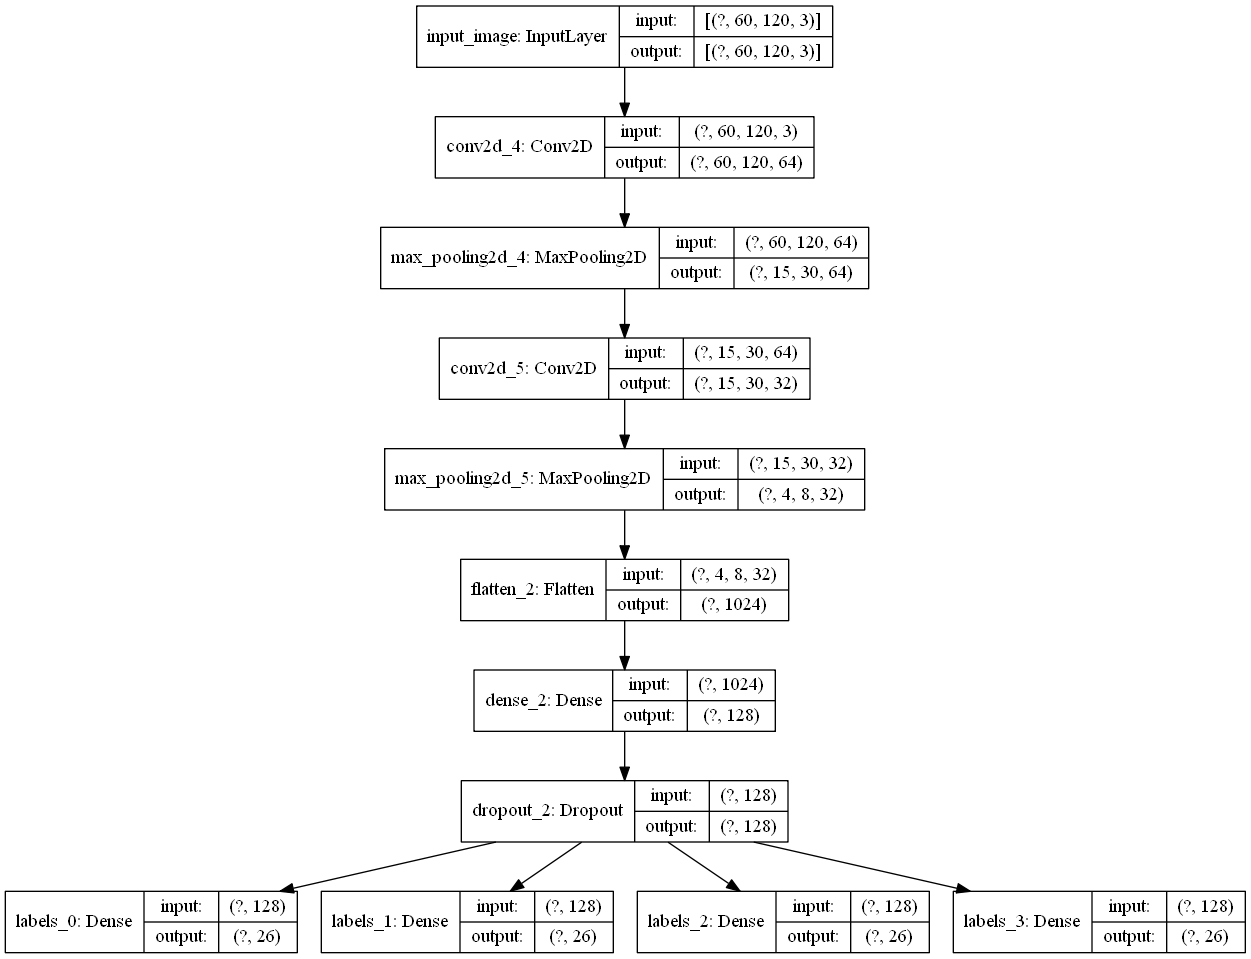

In [17]:
tf.keras.utils.plot_model(model, 'cnn.png', show_shapes=True)

## Train Model

In [18]:
# set loss for each output lables, or set a same loss for all labels
# e.g. loss={ f'labels_{i}': 
#   tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) for i in range(n_labels)}
model.compile(optimizer=tf.keras.optimizers.Adadelta(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
import os
callbacks = [
    # Write TensorBoard logs to `./logs` directory
    tf.keras.callbacks.TensorBoard(log_dir=os.path.join('tensorboard')) # start visualization: tensorboard --logdir mylogdir
]

model.fit(train_ds, epochs=1, callbacks=callbacks)

Train for 708 steps
530/708 [=====================>........] - ETA: 14:08 - loss: 13.0378 - labels_0_loss: 3.2585 - labels_1_loss: 3.2642 - labels_2_loss: 3.2596 - labels_3_loss: 3.2556 - labels_0_accuracy: 0.0471 - labels_1_accuracy: 0.0452 - labels_2_accuracy: 0.0509 - labels_3_accuracy: 0.0465

## Test and Prediction